# Model Agnostic Analysis

## Introduction

*Model agnostic analysis* means writing your notebook so that it can easily be used with any CF-compliant data source.

### What are the CF Conventions?

From [CF Metadata conventions](https://cfconventions.org):

> The CF metadata conventions are designed to promote the processing and sharing of files created with the NetCDF API. The conventions define metadata that provide a definitive description of what the data in each variable represents, and the spatial and temporal properties of the data. This enables users of data from different sources to decide which quantities are comparable, and facilitates building applications with powerful extraction, regridding, and display capabilities. The CF convention includes a standard name table, which defines strings that identify physical quantities.

In most cases the model output data accessed through the ACCESS-NRI Intake Catalog complies with some version of the CF conventions; enough to be usable for model agnostic analysis.

### Why bother?

Model agnostic means the same code can work for multiple models. This makes your code more usable by **you** and by others. You no longer need to have different versions of code for different models. It makes you and any one who uses your code more productive. It allows for common tasks to be abstracted into general methods that can be more easily reused, meaning less code needs to be written and maintained. This is an enormous productivity boost.

### How is model agnostic analysis achieved?

This can be achieved by using packages that enable this:
- [cf_xarray](https://cf-xarray.readthedocs.io/en/latest/index.html) for generalised coordinate naming
- [xgcm](https://xgcm.readthedocs.io) to make grid operations generic across data
- [pint](https://pint.readthedocs.io/) and [pint-xarray](https://pint-xarray.readthedocs.io/) for handling units easily and robustly

## Example

### Introduction

This tutorial uses an example analysis, shows how the this might be done in a traditional, model specific, manner, and then implements the same analysis in a model agnostic way.

This tutorial is intended to be run using the `conda/analysis3` or `conda/access-med` environment, available via the `xp65` project: https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/how.html#using-the-catalog-on-the-are

The first step is to import necessary packages.

In [1]:
import intake

import numpy as np
import xarray as xr
import cf_xarray as cfxr
import pint_xarray

from pint import application_registry as ureg
import cf_xarray.units
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41941,Workers: 14
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:40539,Total threads: 1
Dashboard: /proxy/41883/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:40927,


`cf_xarray` works best when `xarray` keeps attributes by default:

In [3]:
xr.set_options(keep_attrs=True)

Load the ACCESS-NRI Intake Catalog:

In [4]:
catalog = intake.cat.access_nri

Then, select one experiment from the catalog and load surface temperature data from a 0.25$^\circ$ global MOM5 model.

In [5]:
experiment = '025deg_jra55_iaf_omip2_cycle6'
cat_subset = catalog[experiment]

variable = 'sst'
var_search = cat_subset.search(variable=variable, frequency='1mon')
ds = var_search.to_dask(xarray_open_kwargs={
    # This option suppresses a warning due to an upcoming default alteration in xarray
    "decode_timedelta": False,
})
SST = ds[variable]

This is a 3D dataset in latitude, longitude and time:

In [6]:
SST

<xarray.DataArray 'sst' (time: 732, yt_ocean: 1080, xt_ocean: 1440)> Size: 5GB
dask.array<concatenate, shape=(732, 1080, 1440), dtype=float32, chunksize=(1, 216, 240), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Attributes:
    long_name:      Potential temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

### Model specific

First, do our analysis as it might usually be done, in a model-specific manner:

1. Convert the temperature units from kelvin (K) to Celsius (C);
2. Use the time coordinate name in the mean function.

We use `pint` to ensure this is in degrees C. Note that if the data were originally in degrees Celcius, this would do nothing. This is a way of catering for any temperature units that are understood by pint in a transparent way. Note the call to quantify, which invokes pint's machinery to parse the units and allow unit conversions.

In [7]:
SST.attrs['units'] = 'K'
SST = SST.pint.quantify().pint.to('C')
SST_time_mean = SST.mean('time')
SST_time_mean

<xarray.DataArray 'sst' (yt_ocean: 1080, xt_ocean: 1440)> Size: 6MB
<Quantity(dask.array<mean_agg-aggregate, shape=(1080, 1440), dtype=float32, chunksize=(216, 240), chunktype=numpy.ndarray>, 'degree_Celsius')>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
Attributes:
    long_name:      Potential temperature
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

Now, plot the result:

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 16.34 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


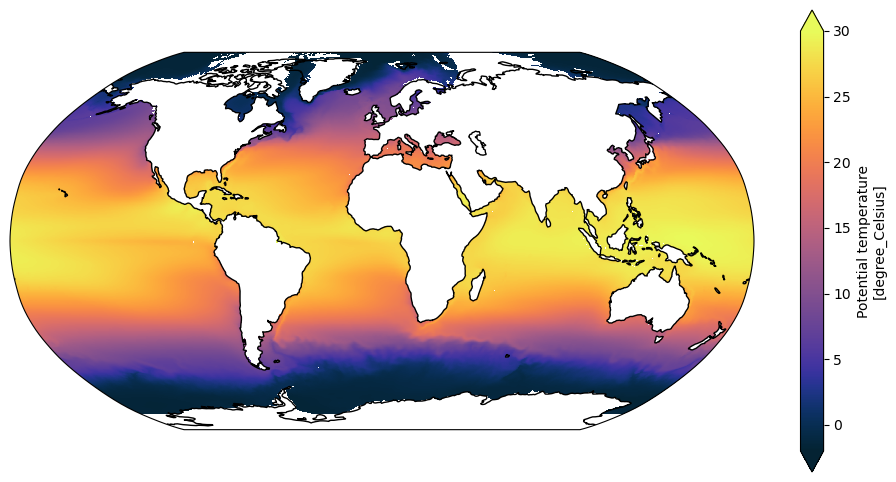

In [8]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())

SST_time_mean.plot(ax=ax,
                   x='xt_ocean', y='yt_ocean', 
                   transform=ccrs.PlateCarree(),
                   vmin=-2, vmax=30, extend='both',
                   cmap=cm.cm.thermal)

ax.coastlines()

(Note that the Arctic is not correctly respresented due to the 1D lat/lon coordinates not being correct in the tripole area. See the [Making Maps with cartopy Tutorial](https://cosima-recipes.readthedocs.io/en/latest/tutorials/Making_Maps_with_Cartopy.html#fixing-the-tripole) for more information.)

### Model agnostic

Now, do the same calculation, but in a model agnostic manner.

We can use the `cf` accessor to automatically determine the name of the time dimension without knowledge of the exact model being used. `cf_xarray` checks the names of variables and coordinates, and associated metadata, to try and infer information about the data based on the CF conventions.

To see what `cf_xarray` information is available just evaluate the accessor:

In [9]:
SST.cf

Coordinates:
             CF Axes: * X: ['xt_ocean']
                      * Y: ['yt_ocean']
                      * T: ['time']
                        Z: n/a

      CF Coordinates: * longitude: ['xt_ocean']
                      * latitude: ['yt_ocean']
                      * time: ['time']
                        vertical: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

In this case it has found `X`, `Y` and `T` axes, and `longitude`, `latitude` and `time` coordinates. These are now accessible like a `dict` using the `cf` accessor. Note that this returns the actual coordinate, and many functions just want a simple string argument, which is the name of the coordinate.

`cf_xarray` also wraps many standard xarray functions, allowing `cf` names to be used, which are [automatically converted to the name in the data](https://cf-xarray.readthedocs.io/en/latest/examples/introduction.html#feature-rewriting-arguments). 

The upshot: just use the `cf` accessor, append the required function, and use the standard CF coordinate name (in this case they are the same, `time`, but that is not guaranteed):

In [10]:
SST_time_mean = SST.cf.mean('time')
SST_time_mean

<xarray.DataArray 'sst' (yt_ocean: 1080, xt_ocean: 1440)> Size: 6MB
<Quantity(dask.array<mean_agg-aggregate, shape=(1080, 1440), dtype=float32, chunksize=(216, 240), chunktype=numpy.ndarray>, 'degree_Celsius')>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
Attributes:
    long_name:      Potential temperature
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

Using the `cf_xarray`-wrapped function makes the code more legible and easier to write, i.e.
```python
SST.cf.mean('time')
```
compared to
```python
SST.mean(SST.cf['time'].name)
```

The `cf` accessor can be used in the same way in the plot, with the CF names for latitude and longitude used as `x` and `y` arguments:

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 16.42 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


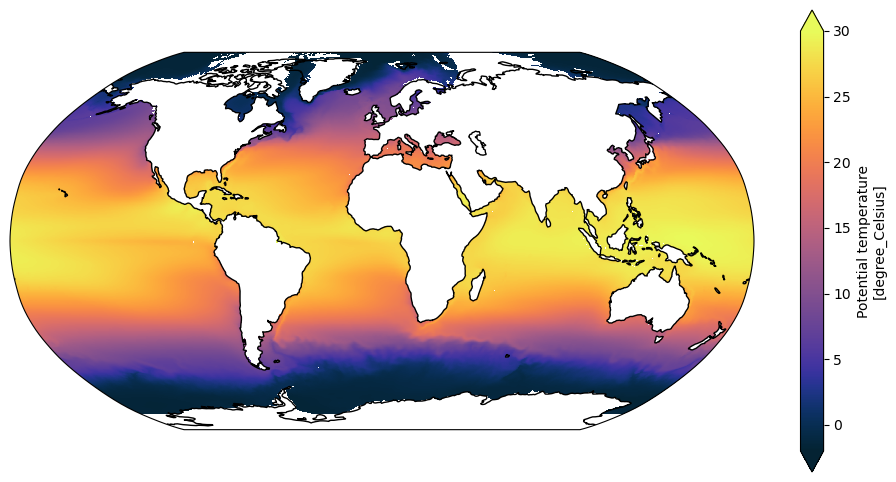

In [11]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())

SST_time_mean.cf.plot(ax=ax,
                      x='longitude', y='latitude', 
                      transform=ccrs.PlateCarree(),
                      vmin=-2, vmax=30, extend='both',
                      cmap=cm.cm.thermal)

ax.coastlines()

## Putting this into practice

Above a model agnostic version of some code was demonstrated, but that doesn't utilise the full power of what it is capable of. The model agnostic code can now be easily turned into a function that accepts an `xarray` `DataArray`:

In [12]:
def map_mean_temp_in_degrees_celsius(da):
    # Take the time mean of da and plot a global temperature field in a Robinson projection
    # 
    # Input DataArray (da) should be a 3D array of latitude, longitude and time.
    
    da = da.pint.quantify().pint.to('C')
    da_time_mean = da.cf.mean('time')
    
    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson())

    da_time_mean.cf.plot(ax=ax,
                         x='longitude', y='latitude', 
                         transform=ccrs.PlateCarree(),
                         vmin=-2, vmax=30, extend='both',
                         cmap=cm.cm.thermal)

    ax.coastlines()

Try this out with the SST data used above:

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 16.42 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


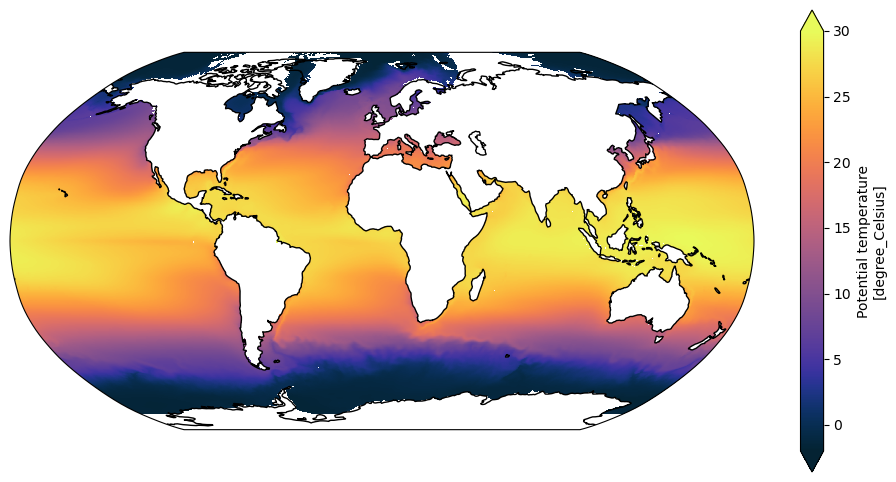

In [13]:
map_mean_temp_in_degrees_celsius(SST)

Now try on the output from a different experiment and model (MOM6):

In [14]:
experiment = 'OM4_025.JRA_RYF'
variable = 'tos'
cat_subset = catalog[experiment]
var_search = cat_subset.search(variable=variable, frequency='1mon')
ds = var_search.to_dask(xarray_open_kwargs={"decode_timedelta": False})
SST_mom6 = ds[variable]

Check to see it has correctly parsed the CF information. It is not necessary to print this out, but interesting, and note it has quite different index and coordinate names

In [15]:
SST_mom6.cf

Coordinates:
             CF Axes: * X: ['xh']
                      * Y: ['yh']
                      * T: ['time']
                        Z: n/a

      CF Coordinates: * longitude: ['xh']
                      * latitude: ['yh']
                      * time: ['time']
                        vertical: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

Use the function from above which also worked on MOM5 data with very different coordinates

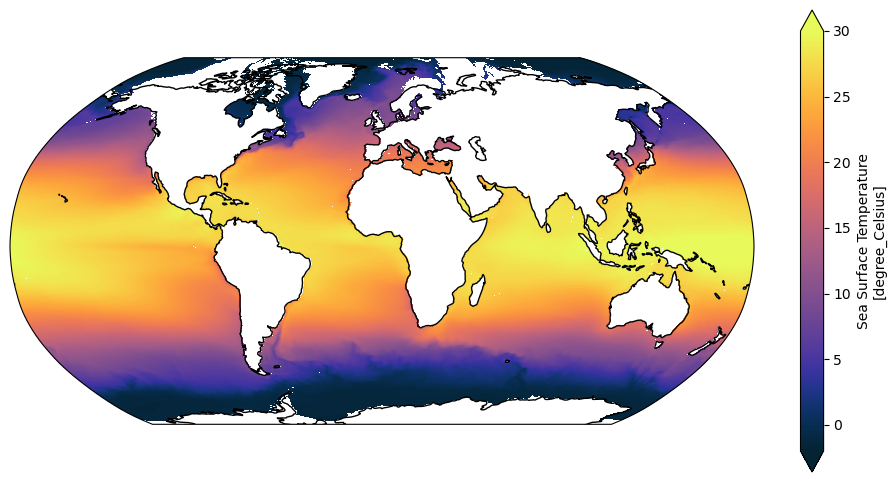

In [16]:
map_mean_temp_in_degrees_celsius(SST_mom6)

## What to do when it goes wrong

The model agnostic function worked flawlessly with two different ocean data sets, after the units were corrected in the MOM5 data. What about some ice data?

Using the same experiment from which the first `SST` data was obtained, load the ice air temperature variable:

In [17]:
catalog.search(name=".*025deg", realm="seaIce", variable="Tair_m")

,model,description,realm,frequency,variable
name,,,,,
025deg_era5_iaf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 interannual\nforcing (1980-2021)},{seaIce},{1mon},{Tair_m}
025deg_era5_ryf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 RYF9091 repeat\nyear forcing (May 1990 to Apr 1991)},{seaIce},{1mon},{Tair_m}
025deg_jra55_iaf_era5comparison,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with JRA55-do v1.5.0\ninterannual forcing (1980-2019)},{seaIce},{1mon},{Tair_m}
025deg_jra55_iaf_omip2_cycle1,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{seaIce},{1mon},{Tair_m}
025deg_jra55_iaf_omip2_cycle2,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{seaIce},{1mon},{Tair_m}
025deg_jra55_iaf_omip2_cycle3,{ACCESS-OM2},{Cycle 3/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{seaIce},{1mon},{Tair_m}
025deg_jra55_iaf_omip2_cycle4,{ACCESS-OM2},{Cycle 4/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{seaIce},{1mon},{Tair_m}
025deg_jra55_iaf_omip2_cycle5,{ACCESS-OM2},{Cycle 5/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{seaIce},{1mon},{Tair_m}
025deg_jra55_iaf_omip2_cycle6,{ACCESS-OM2},{Cycle 6/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{seaIce},{1mon},{Tair_m}


In [18]:
experiment = "025deg_jra55_iaf_omip2_cycle6"
variable = 'Tair_m'
cat_subset = catalog[experiment]
var_search = cat_subset.search(variable=variable, frequency='1mon')
ds = var_search.to_dask(
    xarray_open_kwargs={"decode_timedelta": False},
    # xarray_combine_by_coords_kwargs is required to get the 
    # data from this experiment loaded in a reasonable timeframe
    xarray_combine_by_coords_kwargs = dict(
    compat="override",
    data_vars="minimal",
    coords="minimal",
),
)
ice_air_temp = ds[variable]
ice_air_temp

<xarray.DataArray 'Tair_m' (time: 732, nj: 1080, ni: 1440)> Size: 5GB
dask.array<concatenate, shape=(732, 1080, 1440), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 6kB 1958-02-01 1958-03-01 ... 2019-01-01
    TLON     (nj, ni) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
    TLAT     (nj, ni) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
    ULON     (nj, ni) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
    ULAT     (nj, ni) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          C
    long_name:      air temperature
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

When we try the generic routine:

KeyError: "Receive multiple variables for key 'longitude': ['ULON', 'TLON']. Expected only one. Please pass a list ['longitude'] instead to get all variables matching 'longitude'."

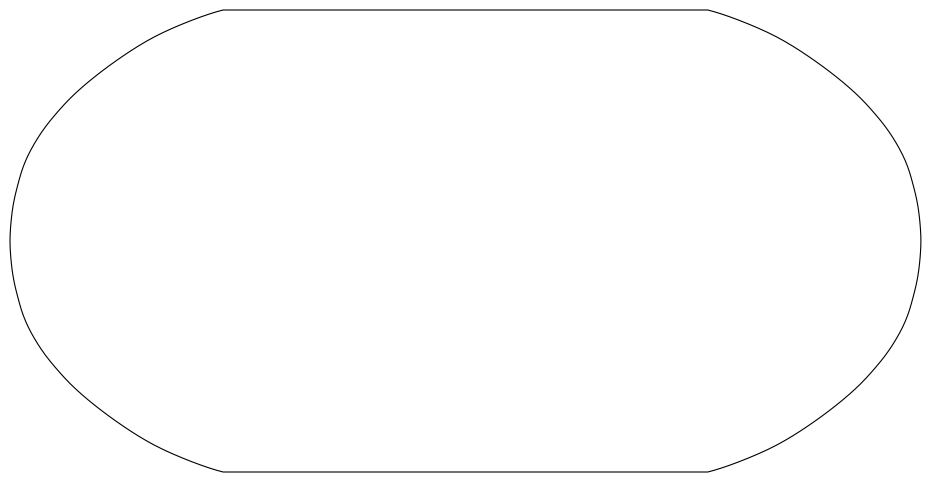

In [19]:
map_mean_temp_in_degrees_celsius(ice_air_temp)

The error message is
```
"Receive multiple variables for key 'longitude': ['TLON', 'ULON']. Expected only one. Please pass a list ['longitude'] instead to get all variables matching 'longitude'."
```
This suggests that `cf_xarray` has found multiple longitude coordinates `TLON` and `ULON` and doesn't know how to resolve this automatically. 

Inspecting the `cf` information doesn't show multiple axes like it [does in the documentation](https://cf-xarray.readthedocs.io/en/latest/examples/introduction.html#what-attributes-have-been-discovered):

In [20]:
ice_air_temp.cf

Coordinates:
             CF Axes:   X, Y, Z, T: n/a

      CF Coordinates:   longitude: ['TLON']
                        latitude: ['TLAT']
                        vertical, time: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

[This is a bug](https://github.com/xarray-contrib/cf-xarray/issues/396), taking the mean alters the coordinates:

In [21]:
ice_air_temp.cf.mean('time').cf

Coordinates:
             CF Axes:   X, Y, Z, T: n/a

      CF Coordinates:   longitude: ['TLON', 'ULON']
                        latitude: ['TLAT', 'ULAT']
                        vertical, time: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

So the solution is to drop the redundant velocity grid:

In [22]:
ice_air_temp = ice_air_temp.drop_vars(['ULON', 'ULAT'])

Now trying to plot again using the generic function and there is another error:

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.MaskedArray with masked values

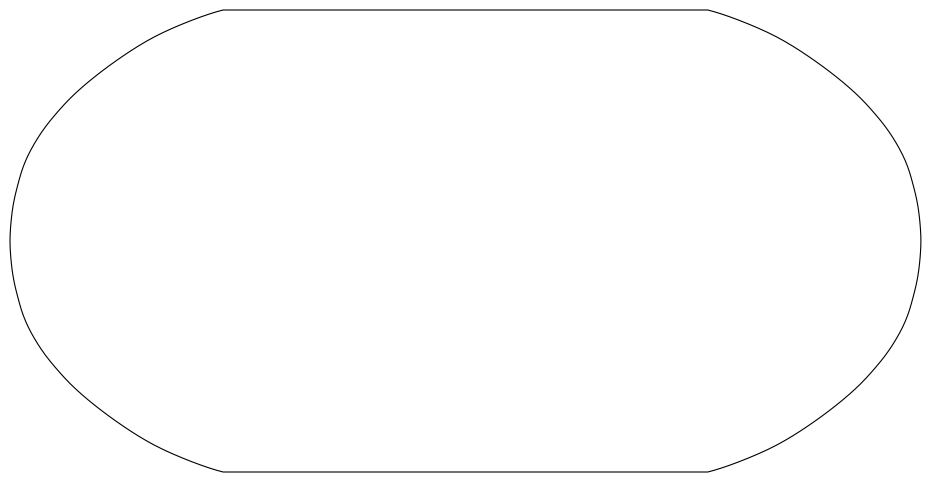

In [23]:
map_mean_temp_in_degrees_celsius(ice_air_temp)

This error:
```term
ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values
```
is because there are `NaN`'s in the coordinate variables, as [explained in the plotting with cartopy tutorial](https://cosima-recipes.readthedocs.io/en/latest/tutorials/Making_Maps_with_Cartopy.html#fixing-the-tripole).

By following the instructions in that tutorial and the [Spatial selection with tripolar ACCESS-OM2 grid notebook](https://cosima-recipes.readthedocs.io/en/latest/documented_examples/Spatial_selection.html#gallery-documented-examples-spatial-selection-ipynb) the coordinates can be fixed by replacing them with coordinates from the ice grid input file. It requires some work, the dimensions must be renamed to match, and coordinates converted from radians to degrees.

In [24]:
ice_grid = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_eee21b65/cice_025deg/grid.nc').rename({'ny': 'nj', 'nx': 'ni'})
ice_grid = ice_grid.pint.quantify()

ice_air_temp = ice_air_temp.assign_coords({'TLON': ice_grid.tlon.pint.to('degrees_E'),
                                           'TLAT': ice_grid.tlat.pint.to('degrees_N')})
ice_air_temp

<xarray.DataArray 'Tair_m' (time: 732, nj: 1080, ni: 1440)> Size: 5GB
dask.array<concatenate, shape=(732, 1080, 1440), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 6kB 1958-02-01 1958-03-01 ... 2019-01-01
    TLON     (nj, ni) float64 12MB [degrees_E] -279.9 -279.6 ... 80.0 80.0
    TLAT     (nj, ni) float64 12MB [degrees_N] -81.08 -81.08 ... 65.13 65.03
Dimensions without coordinates: nj, ni
Attributes:
    units:          C
    long_name:      air temperature
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

Finally, the generic plotting routine works:

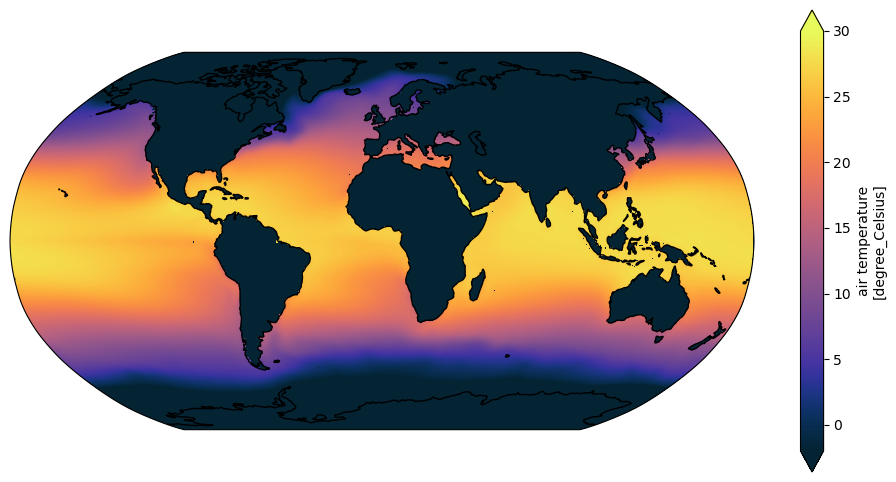

In [25]:
map_mean_temp_in_degrees_celsius(ice_air_temp)

One more step is to modify the original routine to take the vertical range as an argument, so it is more generally useful:

In [26]:
def map_mean_temp_in_degrees_celsius(da, vmin=-2, vmax=30):
    # Take the time mean of da and plot a global temperature field in a Robinson projection
    # 
    # Input DataArray (da) should be a 3D array of latitude, longitude and time.
    
    da = da.pint.quantify().pint.to('C')
    da_time_mean = da.cf.mean('time')
    
    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson())

    da_time_mean.cf.plot(ax=ax,
                         x='longitude', y='latitude', 
                         transform=ccrs.PlateCarree(),
                         vmin=vmin, vmax=vmax, extend='both',
                         cmap=cm.cm.thermal)

    ax.coastlines()

By specifying default values for the arguments it is completely backwards compatible, we have lost no functionality, but the ice air temperature can now be plotted with a range that better suits the range of the data

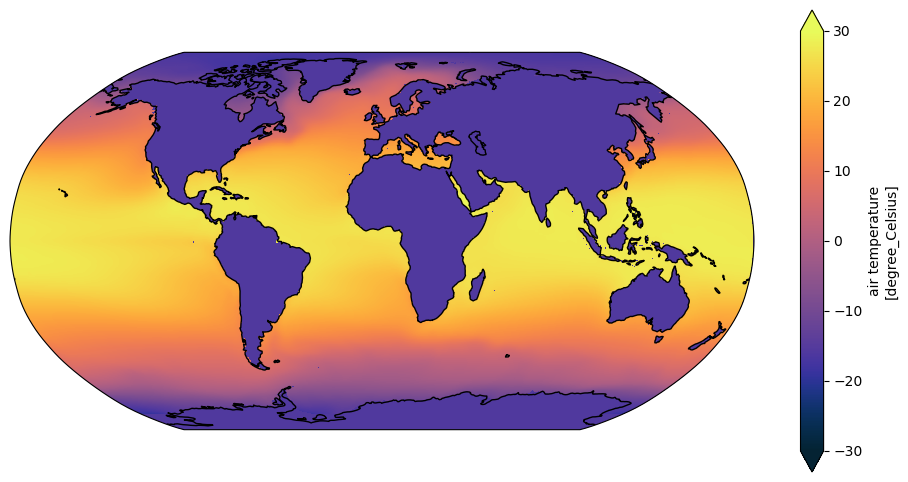

In [27]:
map_mean_temp_in_degrees_celsius(ice_air_temp, vmin=-30)

## Conclusion

Model-specific code to take a time mean and plot the data was converted to a model agnostic function with no loss of functionality.

The same function can be used with a wide range CF-compliant data.

In some cases the input data will need to be modified if it is not sufficiently compliant, or non-conforming in some way (such as the ice data above with `NaN`'s in the coordinate). It is better to modify the data to be more compliant and higher quality, and use generic tools, than have multiple code versions to account for the vagaries or problems of individual datasets. 

Ideally, those improvements can be incorporated into future versions of the data at source, in post-processing, or in some utility functions for transforming a class of non-conforming data.

In [28]:
client.close()